In [54]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [99]:
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import xgboost as xgb

In [7]:
boston = load_boston()
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [12]:
data = pd.DataFrame(boston.data, columns=boston.feature_names)
data['PRICE'] = boston.target
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [13]:
data.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [27]:
# Predict PRICE
X, y = data.iloc[:,:-1],data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print('Train:', (X_train.shape, y_train.shape), '\nTest:',(X_test.shape,y_test.shape))

Train: ((404, 13), (404,)) 
Test: ((102, 13), (102,))


## XGBoost's hyperparameters
At this point, before building the model, you should be aware of the tuning parameters that XGBoost provides. Well, there are a plethora of tuning parameters for tree-based learners in XGBoost and you can read all about them [here](http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters). But the most common ones that you should know are:

- `learning_rate`: step size shrinkage used to prevent overfitting. Range is [0,1]
- `max_depth`: determines how deeply each tree is allowed to grow during any boosting round.
- `subsample`: percentage of samples used per tree. Low value can lead to underfitting.
- `colsample_bytree`: percentage of features used per tree. High value can lead to overfitting.
- `n_estimators`: number of trees you want to build.
- `objective`: determines the loss function to be used like 
  - `reg:linear`(`reg:squarederror`) for regression problems, 
  - `reg:logistic` for classification problems with only decision, 
  - `binary:logistic` for classification problems with probability.

XGBoost also supports regularization parameters to penalize models as they become more complex and reduce them to simple (parsimonious) models.

- `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- `alpha`: L1 regularization on leaf weights. A large value leads to more regularization.
- `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.


In [20]:
# xgb structure for faster train
data_dmatrix = xgb.DMatrix(data=X,label=y)
data_dmatrix

In [53]:
# XBoost way
params = {"objective":"reg:squarederror",
          'colsample_bytree': 0.3,
          'learning_rate': 0.1,
          'max_depth': 5, 
          'alpha': 10
          }

cv_results = xgb.cv(dtrain=data_dmatrix, 
                    params=params, 
                    nfold=3,
                    num_boost_round=50,
                    early_stopping_rounds=10,
                    metrics="rmse", 
                    as_pandas=True, 
                    seed=123)

In [49]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.679234,0.025626,21.677613,0.050617
1,19.772293,0.016054,19.773320,0.020571
2,18.049563,0.058904,18.065856,0.082746
3,16.430113,0.013615,16.492199,0.020919
4,15.025977,0.062132,15.132644,0.073104
5,13.751878,0.071229,13.915182,0.105037
6,12.594594,0.050818,12.836291,0.092982
7,11.577890,0.075426,11.879440,0.108604
8,10.707665,0.095779,11.065584,0.111040
9,9.858511,0.084696,10.248752,0.055924


### SKLearn api

In [73]:
# Sklearn way 
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                max_depth = 5, 
                alpha = 10, 
                n_estimators = 50)

In [74]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

In [75]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 4.051055


### Grid Search

In [115]:
params = {"objective":["reg:squarederror"],
          'colsample_bytree': [0, 0.1, 0.3],
          'learning_rate': [0.001, 0.1, 0.5, 1],
          'max_depth': [1, 5, 10], 
          'alpha': [0, 5, 10],
          'n_estimators': [0, 10, 20, 50, 60]
          }

model = xgb.XGBRegressor()
xgb_grid = GridSearchCV(model, 
                        params, 
                        # scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs = 5)

xgb_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, r...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=5,
             param_grid={'alpha': [0, 5, 10], 'colsample_bytree': [0, 0.1, 0.3],
                         'learning_rate': [0.001, 0.1, 0.5, 

In [116]:
print(xgb_grid.best_params_)
print(xgb_grid.best_score_)


preds = xgb_grid.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

{'alpha': 0, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 60, 'objective': 'reg:squarederror'}
0.8425080722202818
RMSE: 4.005693


In [127]:
# Leadeboard
cv_data = pd.DataFrame(xgb_grid.cv_results_)
cv_data.sort_values('rank_test_score').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_objective,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
144,0.093116,0.009537,0.005229,0.002922,0,0.3,0.1,5,60,reg:squarederror,"{'alpha': 0, 'colsample_bytree': 0.3, 'learnin...",0.868107,0.879138,0.873145,0.826489,0.765662,0.842508,0.042656,1
504,0.084171,0.005713,0.007004,0.003761,10,0.3,0.1,5,60,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.3, 'learni...",0.868107,0.879138,0.873145,0.826489,0.765662,0.842508,0.042656,1
324,0.092626,0.006726,0.008154,0.003300,5,0.3,0.1,5,60,reg:squarederror,"{'alpha': 5, 'colsample_bytree': 0.3, 'learnin...",0.868107,0.879138,0.873145,0.826489,0.765662,0.842508,0.042656,1
503,0.076498,0.007227,0.006152,0.005154,10,0.3,0.1,5,50,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.3, 'learni...",0.861754,0.864653,0.866375,0.829193,0.758238,0.836043,0.041231,4
143,0.068710,0.012514,0.007608,0.006607,0,0.3,0.1,5,50,reg:squarederror,"{'alpha': 0, 'colsample_bytree': 0.3, 'learnin...",0.861754,0.864653,0.866375,0.829193,0.758238,0.836043,0.041231,4
323,0.075606,0.007455,0.002462,0.000028,5,0.3,0.1,5,50,reg:squarederror,"{'alpha': 5, 'colsample_bytree': 0.3, 'learnin...",0.861754,0.864653,0.866375,0.829193,0.758238,0.836043,0.041231,4
149,0.133464,0.011705,0.008278,0.004591,0,0.3,0.1,10,60,reg:squarederror,"{'alpha': 0, 'colsample_bytree': 0.3, 'learnin...",0.852899,0.864300,0.857591,0.825190,0.739241,0.827844,0.046258,7
509,0.123110,0.011189,0.007666,0.004114,10,0.3,0.1,10,60,reg:squarederror,"{'alpha': 10, 'colsample_bytree': 0.3, 'learni...",0.852899,0.864300,0.857591,0.825190,0.739241,0.827844,0.046258,7
329,0.132638,0.008241,0.011491,0.003368,5,0.3,0.1,10,60,reg:squarederror,"{'alpha': 5, 'colsample_bytree': 0.3, 'learnin...",0.852899,0.864300,0.857591,0.825190,0.739241,0.827844,0.046258,7
148,0.105079,0.010983,0.008976,0.003365,0,0.3,0.1,10,50,reg:squarederror,"{'alpha': 0, 'colsample_bytree': 0.3, 'learnin...",0.849396,0.854793,0.853439,0.828046,0.734785,0.824092,0.045685,10


# Visualize

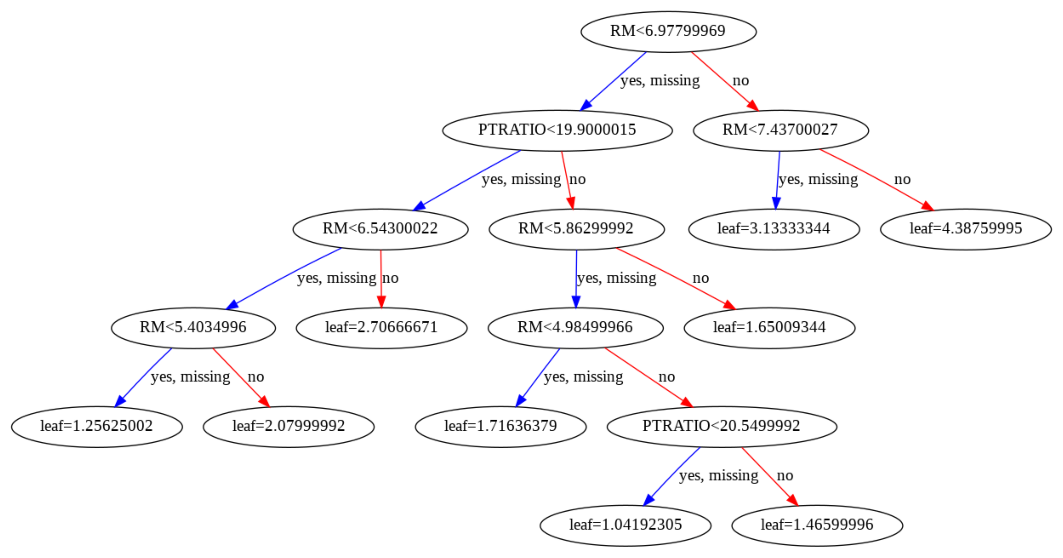

In [77]:
# Visualize tree

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

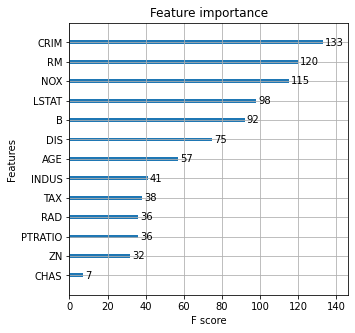

In [79]:
# Visualize important feature

xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 10]
plt.show()